In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./Y_train.csv', index_col=0)

train_home_team_statistics_df.columns = 'HOME_' + train_home_team_statistics_df.columns
train_away_team_statistics_df.columns = 'AWAY_' + train_away_team_statistics_df.columns

train_data = train_home_team_statistics_df.iloc[:,2:].join(train_away_team_statistics_df.iloc[:,2:])

In [3]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
class MatchTeamClassifier(nn.Module):
    def __init__(self, n_class, n_team_fts, hidden_team):
        super().__init__()
        self.bc1 = nn.BatchNorm1d(n_team_fts)
        self.bc2 = nn.BatchNorm1d(hidden_team[0])
        self.bc3 = nn.BatchNorm1d(hidden_team[1])
        self.att1 = nn.MultiheadAttention(hidden_team[0], 1, batch_first=True)
        self.att2 = nn.MultiheadAttention(hidden_team[0], 1, batch_first=True)
        self.fc1 = nn.Linear(n_team_fts, hidden_team[0])
        self.fc2 = nn.Linear(hidden_team[0], hidden_team[1])
        #self.bc2 = nn.BatchNorm1d(hidden_team)
        self.fc3 = nn.Linear(hidden_team[0], n_class)

    def forward(self, x):
        res = self.bc2(self.fc1(self.bc1(x)))[:,None,:]
        res = self.att1(res, res, res, need_weights=False)[0]
        #res = self.fc3(F.relu(self.fc2(self.att2(res, res, res, need_weights=False)[0])))
        return self.fc3(res)[:,0,:]

In [46]:
net = MatchTeamClassifier(3, 280, (128, 64))

x_train = torch.Tensor(X_train.replace({np.nan:0.0}).values)
x_valid = torch.Tensor(X_valid.replace({np.nan:0.0}).values)
Y_train = torch.Tensor(y_train.values)
Y_valid = torch.Tensor(y_valid.values)

In [47]:
print(net(x_valid).shape)
net.bc1.requires_grad_(False)

torch.Size([2461, 3])


BatchNorm1d(280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [48]:
import copy

N_EPOCHS = 10000 # + 100
net.train()
criterion = nn.CrossEntropyLoss() # loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

train_accuracies = [1.0]
val_accuracies = [1.0]
val_check = 1
best_state, best_val = None, 0.0
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform SGD step.
    optimizer.zero_grad()
    y_pred = net(x_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()
    train_acc, val_acc = accuracy_score(torch.argmax(y_pred, axis=1), torch.argmax(Y_train, axis=1)), val_accuracies[-1]
    if(epoch % val_check == 0):
        hat_y_val = net(x_valid)
        #val_loss = criterion(hat_y_val, y_val)
        val_acc = accuracy_score(torch.argmax(hat_y_val, axis=1), torch.argmax(Y_valid, axis=1))
        if(val_acc > best_val):
            best_val = val_acc
            best_state = copy.deepcopy(net.state_dict())

    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")

Epoch 0 Loss 1.12 | Train Accuracy 0.3359073359073359 | Val Accuracy 0.4368143031288094
Epoch 1 Loss 1.08 | Train Accuracy 0.45854501117659013 | Val Accuracy 0.46525802519301096
Epoch 2 Loss 1.03 | Train Accuracy 0.47297297297297297 | Val Accuracy 0.4660707029662739
Epoch 3 Loss 1.04 | Train Accuracy 0.47876447876447875 | Val Accuracy 0.4782608695652174
Epoch 4 Loss 1.03 | Train Accuracy 0.4892298313350945 | Val Accuracy 0.47785453067858596
Epoch 5 Loss 1.02 | Train Accuracy 0.4895346474293843 | Val Accuracy 0.48029256399837467
Epoch 6 Loss 1.02 | Train Accuracy 0.4899410688884373 | Val Accuracy 0.4863876472978464
Epoch 7 Loss 1.01 | Train Accuracy 0.49339565129038815 | Val Accuracy 0.4961397805770012
Epoch 8 Loss 1.01 | Train Accuracy 0.4973582605161552 | Val Accuracy 0.4928890694839496
Epoch 9 Loss 1.02 | Train Accuracy 0.497663076610445 | Val Accuracy 0.49207639171068673
Epoch 10 Loss 1.01 | Train Accuracy 0.4994919731761837 | Val Accuracy 0.49085737505079235
Epoch 11 Loss 1.01 | Tr

KeyboardInterrupt: 

In [44]:
print(net.state_dict())

OrderedDict([('bc1.weight', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

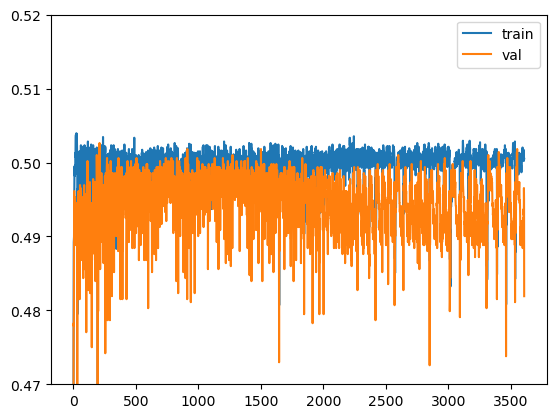

In [49]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_accuracies[1:])), train_accuracies[1:], label = "train")
plt.plot(np.arange(len(train_accuracies[1:])), val_accuracies[1:], label = "val")
plt.legend(loc="best")
plt.ylim(0.47, 0.52)
plt.show()

In [22]:
#print(val_accuracies)
#print(train_accuracies)
torch.save(best_state, "MCT_params_best2")
#torch.save(net.state_dict(), "MCT_params_last")
#net = MatchClassifier(3,4,302,278,300)
#net.load_state_dict(torch.load("MC1_params"))

In [25]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
#print(val_accuracies)
#print(train_accuracies)
#torch.save(net.state_dict(), "MC1_params")
net = MatchTeamClassifier(3,280,(512,64))
net.load_state_dict(torch.load("MCT_params_best2"))

hat_y_val = torch.argmax(net(x_valid), axis=1)
y_val = torch.argmax(Y_valid, axis=1)
#print(confusion_matrix(y_val, hat_y_val, normalize="pred"))
#print(np.unique(torch.argmax(Y_valid, axis=1), return_counts=True))
print(accuracy_score(y_val, hat_y_val))

0.5030475416497359


## Submission

In [26]:
test_home_team_statistics_df = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)

test_home_team_statistics_df.columns = 'HOME_' + test_home_team_statistics_df.columns
test_away_team_statistics_df.columns = 'AWAY_' + test_away_team_statistics_df.columns

test_data = test_home_team_statistics_df.join(test_away_team_statistics_df)

In [27]:
net.eval()
d = {'HOME_WINS':[0 for i in range(len(test_data))], 'DRAW':[0 for i in range(len(test_data))], "AWAY_WINS":[0 for i in range(len(test_data))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)
y_pred = net(torch.Tensor(test_data.replace({np.nan:0.0}).values))
scores = torch.argmax(y_pred, axis=1)
test_score.iloc[scores == 0, 0] = 1
test_score.iloc[scores == 1, 1] = 1
test_score.iloc[scores == 2, 2] = 1
test_score.reset_index(inplace=True)
test_score.to_csv("MCT.csv", index=False)